## Stock market prediction based on patent novelty


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/all_novelty.csv")
stock_prices = pd.read_csv("data/stockprices_2000_2020.csv")
print(df.shape)
print(stock_prices.shape)

(427, 15)
(369810, 3)


In [3]:
df.ticker.value_counts()

ticker
CL     335
CHD     70
HSY     18
CPB      4
Name: count, dtype: int64

In [4]:
stock_prices = stock_prices[(stock_prices["Ticker"]=="CL") | 
                            (stock_prices["Ticker"]=="CHD") |
                            (stock_prices["Ticker"]=="HSY") |
                            (stock_prices["Ticker"]=="CPB")]
stock_prices.shape

(21132, 3)

In [5]:
# Keeping range of dates for which we have patent data

stock_prices["date"] = pd.to_datetime(stock_prices["Date"])
df["date"] = pd.to_datetime(df["issue_date"])
stock_prices = stock_prices[(stock_prices["date"]>=df.date.min()) &
                            (stock_prices["date"]<=df.date.max())]
stock_prices = stock_prices.drop(columns=["Date"])

stock_prices = stock_prices.rename(columns={'Ticker': 'ticker'})

In [6]:
# Many patents are published on the same date - we average the novelty measures

df_reduc = df.drop(columns=["text", "patent_id", "clean_corpus", "issue_date"])
df2_avg = df_reduc.groupby(['ticker', 'date', 'sector']).mean().reset_index()
df2_avg.shape

(256, 12)

In [7]:
# Merging the two datasets
merged = pd.merge(stock_prices, df2_avg, on=["date", "ticker"], how="left")
merged.shape

(8928, 13)

We end up with a dataset with a lot of NA values, since we have data for 8928 days/tickers, but new patents were only released in 256 cases.

In [8]:
merged.to_csv("data/stockprices_novelty_merged.csv")

## Preprocessing and modelling

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error

In [32]:
df = pd.read_csv("data/stockprices_novelty_merged.csv").drop(columns=["Unnamed: 0"])

# Sector does not give us extra information

df = df.drop(columns=["sector"])

# Calculate the maximum value within each group
numpatents = df.groupby('ticker')['numpat_total'].transform('max')

# Assign the maximum values to a new column 'max_value'
df['numpat_total'] = numpatents

test_time_start = '2017'

df = df.fillna(0) # Filling NAs with 0 (signaling "no innovation")

df["date"] = pd.to_datetime(df["date"])

df.sort_values(['ticker', 'date'], inplace=True)


### Benchmark

+ Naive model

In [48]:
test_time_start = '2017-01-01'
train = df.loc[df.date < test_time_start]
test = df.loc[df.date >= test_time_start]

companies = df['ticker'].unique()

def apply_naive_prediction(train, test, target, companies):
    y_pred = []  # Initialize y_pred as an empty list
    for c in companies:
        train_c = train[train["ticker"]==c]
        test_c = test[test["ticker"]==c]

        y_pred_1 = train_c[target].iloc[-1]
        y_pred_2 = test_c[target].shift(1)  # Shift the values by 1 timestep
        y_pred_c = y_pred_2.fillna(y_pred_1)
        y_pred.append(y_pred_c)  # Append the predicted values to y_pred list

    return pd.concat(y_pred)  # Concatenate the predicted values into a single series or dataframe


y_pred = apply_naive_prediction(train, test, "Adj Close", companies)

mse = mean_squared_error(test["Adj Close"], y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.00033931651339462644


### Model 1
+ Effect of new patent on the following day. 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Fixed effects by company (ticker dummies).
+ Include past information for stock market variation (lags)
+ Model: RF + hyperparameter tunning

In [49]:
# Shifting target by 1 day

# Function for defining Y variable

def make_target(df, t):
    '''t is the number of periods to shift forward'''
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by=['ticker', 'date'])

    # loop through each period and generate the shift variables
    for i in range(1, t+1):
        col_name = f'Adj Close{i}'
        df[col_name] = df.groupby(['ticker'])['Adj Close'].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_f{}'.format(t)] = df[[f'Adj Close{i}' for i in range(1, t+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'Adj Close{i}' for i in range(1, t+1)])

    return(df)

In [53]:
df_target = make_target(df, 1)
df_target.tail()

,ticker,Adj Close,date,numpat_total,avg_similarity_5,avg_similarity_10,avg_similarity_20,nw,nb,nt,nwc,nov,target_f1
8923,HSY,0.003343,2018-11-07,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.009070
8924,HSY,-0.009070,2018-11-08,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.014103
8925,HSY,0.014103,2018-11-09,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000829
8926,HSY,0.000829,2018-11-12,27.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.004325
8927,HSY,0.004325,2018-11-13,27.0,0.235248,0.138532,0.097133,0.0,0.0,0.0,0.0,0.0,NaN


In [54]:
# Here we generate variables for the past 3 to 120 days with a rolling mean of Adj Close
df_target["date"] = pd.to_datetime(df_target["date"])
panel_data= df_target.copy()
panel_data = panel_data.sort_values(by=['ticker', 'date'])
lcols = (panel_data.groupby(['ticker'])['Adj Close'] 
         .transform(lambda x: x.rolling(w, min_periods=1).sum()) # rolling sum of number of reports
         .rename('past' + str(w-1)) 
         for w in [4, 7, 16, 31, 61, 121])
panel_data = panel_data.join(pd.DataFrame(lcols).transpose())

In [57]:
# OHE for ticker

dummies = pd.get_dummies(panel_data['ticker'], dtype=int)
merged = pd.concat([panel_data, dummies], axis=1)

merged = merged.drop(columns=["ticker", "Adj Close"])


In [68]:
# Split the data into training and test 
train = merged.loc[merged.date < test_time_start]
test = merged.loc[merged.date >= test_time_start]
test = test.dropna()

X_train = train.drop('target_f1', axis=1).drop(columns=["date"])  # Features
y_train = train['target_f1']  # Target variable
X_test = test.drop('target_f1', axis=1).drop(columns=["date"])  # Features
y_test = test['target_f1']  # Target variable

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both the training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00017210385348447716


In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

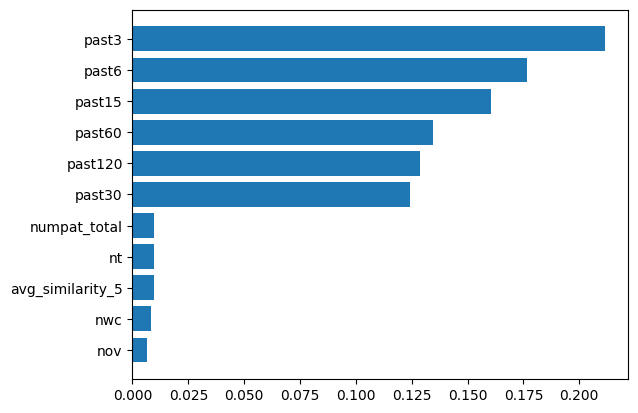

[8, 7, 1, 6, 0, 12, 14, 13, 11, 10, 9]

In [72]:
feature_names = X_train.columns

feature_imp(abs(best_model.feature_importances_), feature_names)

### Model 2

+ Effect of new patent on the following day. 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Instead of fixed effects by company (ticker dummies), one model per company.
+ Include past information for stock market variation (lags)
+ Model: RF + hyperparameter tunning



In [77]:
df_copy = panel_data.copy()


# Drop unnecesary columns
df_copy = df_copy.drop(columns=["Adj Close"])

In [79]:
df_copy = panel_data.copy()


# Drop unnecesary columns
df_copy = df_copy.drop(columns=["Adj Close"])

# Get the unique company names from the DataFrame
companies = df_copy['ticker'].unique()

# Create an empty dictionary to store the trained models and MSE values
results = {}

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

# Iterate over the companies
for company in companies:
    # Subset the data for the current company
    company_data = df_copy[df_copy['ticker'] == company]
    company_data = company_data.dropna()
    company_data = company_data.drop(columns=["ticker"])
   # Split the data into training and test 
    train = company_data.loc[company_data.date < test_time_start]
    test = company_data.loc[company_data.date >= test_time_start]

    X_train = train.drop('target_f1', axis=1).drop(columns=["date"])  # Features
    y_train = train['target_f1']  # Target variable
    X_test = test.drop('target_f1', axis=1).drop(columns=["date"])  # Features
    y_test = test['target_f1']  # Target variable

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler on the training features
    scaler.fit(X_train)

    # Apply the scaler to both the training and test features
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

  
    # Perform grid search for hyperparameter tuning
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions using the selected model
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate the mean squared error for the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Store the best model and MSE in the dictionary
    results[company] = {
        'model': best_model,
        'mse': mse
    }



In [80]:
results

{'CHD': {'model': RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=300,
                        random_state=42),
  'mse': 0.00015222288621109453},
 'CL': {'model': RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=200,
                        random_state=42),
  'mse': 0.00013764454825737616},
 'CPB': {'model': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42),
  'mse': 0.0002777173278876941},
 'HSY': {'model': RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=50,
                        random_state=42),
  'mse': 0.0001273804779564348}}

### Model 3
+ ARIMA

In [73]:
# !pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [75]:
df_timeseries = df.copy()

df_timeseries["date"] = pd.to_datetime(df_timeseries["date"])

# Set the 'date' column as the index
df_timeseries.set_index('date', inplace=True)



In [76]:


import warnings
warnings.filterwarnings("ignore")

# Specify the order of the ARIMA model (p, d, q)
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

for company in companies:
    # Subset the data for the current company
    df_company = df_timeseries[df_timeseries['ticker'] == company].copy()
    # Resample time series because it only includes business days
    df_company = df_company.resample('B').interpolate()
    # Separate the target variable (stock values) and covariates
    y = df_company['Adj Close']
    X = df_company.drop(columns=["Adj Close", "ticker"])

    # Split the data into train and test based on date
    test_start_date = pd.to_datetime('2017-01-01')
    X_train = X[X.index < test_start_date]
    X_test = X[X.index >= test_start_date]
    y_train = y[y.index < test_start_date]
    y_test = y[y.index >= test_start_date]

    # Standardize the covariates using a scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled arrays back to a DataFrame with original column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Fit the ARIMA model with exogenous variables
    model = ARIMA(y_train, order=(p, d, q), exog=X_train_scaled)
    model_fit = model.fit()

    print("--------------------------")
    print(f"Company: {company}")
    print(model_fit.summary())
    # Make predictions on the test set with exogenous variables
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

    # Calculate the mean squared error (MSE) on the test set
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")



--------------------------
Company: CHD
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1824
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5577.869
Date:                Thu, 08 Jun 2023   AIC                         -11131.737
Time:                        17:15:54   BIC                         -11065.638
Sample:                    01-05-2010   HQIC                        -11107.353
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
numpat_total               0         -0        nan        nan           0           0
avg_similarity_5     -0.0020      0.001     -1.753      0.080      -0.